# cnn-fashion-mnist

Follow along with the tutorial at:
https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-fashion-mnist-clothing-classification/

## Imports

In [35]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import KFold

from timeit import default_timer as timer

In [18]:
from keras.datasets import fashion_mnist
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD

 ## Some rough work to look at the fashion mnist dataset.

In [14]:
# load dataset.
(trainX, trainY), (testX, testY) = fashion_mnist.load_data()

# Summarize loaded dataset.
print('Train: X=%s, Y=%s' % (trainX.shape, trainY.shape))
print('Test: X=%s, Y=%s' % (testX.shape, testY.shape))

Train: X=(60000, 28, 28), Y=(60000,)
Test: X=(10000, 28, 28), Y=(10000,)


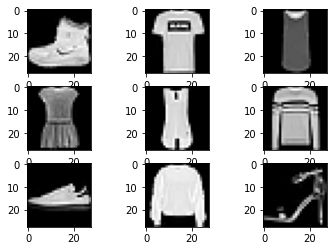

In [12]:
# Plot first few images.
for i in range(9):
    # define subplot
    plt.subplot(330 + 1 + i)
    # plot raw pixel data
    plt.imshow(trainX[i], cmap=plt.get_cmap('gray'))
    
# Show the figure.
plt.show()

Reshape the dataset to have a single channel. Each image is 28x28 grayscale (= single color channel).

In [15]:
trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
testX = testX.reshape((testX.shape[0], 28, 28, 1))

Use one hot encoding for the 10 classes represented by integers 0 - 9. Transform the integer into a 10 element binary vector with a 1 for the index of the class value.

In [20]:
# one hot encode target values
trainY = to_categorical(trainY)
testY = to_categorical(testY)

Pixels are unsigned integers. rescale to range [0,1].

In [24]:
# convert from integers to floats
train_norm = trainX.astype('float32')
test_norm = testX.astype('float32')
# normalize to range 0-1
train_norm = train_norm / 255.0
test_norm = test_norm / 255.0

## Define a function to load the training and test data.

In [22]:
# load train and test dataset
def load_dataset():
    """
    Load the train/test data. Reshape it. Apply one hot encoding.
    """
    # load dataset
    (trainX, trainY), (testX, testY) = fashion_mnist.load_data()
    # reshape dataset to have a single channel
    trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
    testX = testX.reshape((testX.shape[0], 28, 28, 1))
    # one hot encode target values
    trainY = to_categorical(trainY)
    testY = to_categorical(testY)
    return trainX, trainY, testX, testY

## Function to scale the pixel values.

In [25]:
def prep_pixels(train, test):
    """
    Scale pixels.
    """
    # convert from integers to floats
    train_norm = train.astype('float32')
    test_norm = test.astype('float32')
    
    # normalize to range 0-1
    train_norm = train_norm / 255.0
    test_norm = test_norm / 255.0
    
    # return normalized images
    return train_norm, test_norm

In [26]:
# define cnn model
def define_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(10, activation='softmax'))
    
    # compile model
    opt = SGD(lr=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [27]:
# evaluate a model using k-fold cross-validation
def evaluate_model(dataX, dataY, n_folds=5):
    scores, histories = list(), list()
    
    # prepare cross validation
    kfold = KFold(n_folds, shuffle=True, random_state=1)
    
    # enumerate splits
    for train_ix, test_ix in kfold.split(dataX):
        
        # define model
        model = define_model()
        
        # select rows for train and test
        trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
        
        # fit model
        history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY), verbose=0)
        
        # evaluate model
        _, acc = model.evaluate(testX, testY, verbose=0)
        print('> %.3f' % (acc * 100.0))
        
        # append scores
        scores.append(acc)
        histories.append(history)
    return scores, histories

In [28]:
# plot diagnostic learning curves
def summarize_diagnostics(histories):
    for i in range(len(histories)):
        
        # plot loss
        plt.subplot(211)
        plt.title('Cross Entropy Loss')
        plt.plot(histories[i].history['loss'], color='blue', label='train')
        plt.plot(histories[i].history['val_loss'], color='orange', label='test')
        
        # plot accuracy
        plt.subplot(212)
        plt.title('Classification Accuracy')
        plt.plot(histories[i].history['accuracy'], color='blue', label='train')
        plt.plot(histories[i].history['val_accuracy'], color='orange', label='test')
    plt.show()

In [32]:
# summarize model performance
def summarize_performance(scores):
    
    # print summary
    print('Accuracy: mean=%.3f std=%.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))
   
    # box and whisker plots of results
    plt.boxplot(scores)
    plt.show()

In [30]:
# run the test harness for evaluating a model
def run_test_harness():
    
    # load dataset
    trainX, trainY, testX, testY = load_dataset()
    
    # prepare pixel data
    trainX, testX = prep_pixels(trainX, testX)
    
    # evaluate model
    scores, histories = evaluate_model(trainX, trainY)
    
    # learning curves
    summarize_diagnostics(histories)
    
    # summarize estimated performance
    summarize_performance(scores)

> 91.017
> 90.842
> 90.975
> 91.292
> 91.125


<ipython-input-28-c533f05b91bb>:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(211)
<ipython-input-28-c533f05b91bb>:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(212)


NameError: name 'plot' is not defined

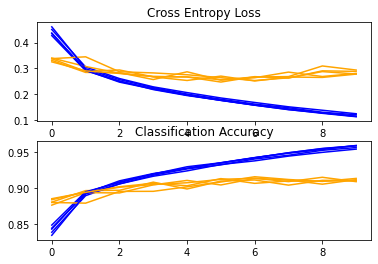

In [31]:
# entry point, run the test harness
start = timer()
run_test_harness()
end = timer()
print(end - start) # Time in seconds, e.g. 5.38091952400282